In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [3]:
# Path to the dataset from Adafruit.io
# Change <PATH-TO-DATASET> to the file name of the Adafruit.io data you downloaded.
dataset_path = './dataset/raw/known_good.csv'

# Load the dataset using pandas
df = pd.read_csv(dataset_path, usecols=[1], header=None)

df

,1
0,-19.5625
1,-19.6250
2,-19.6250
3,-19.6875
4,-19.6875
...,...
228512,-18.2500
228513,-18.2500
228514,-18.2500
228515,-18.1875


In [4]:
# Caluclate the number of data points to include in each row of the table
# The sample rate should match the code on your temperature monitor

def hours_to_seconds(hours):
    return hours * 3600

sample_rate = 0.2   # Hz (samples per second)
sample_time = 1     # Hours
datapoints_per_row = sample_rate * hours_to_seconds(sample_time)

In [5]:
# Restructure the dataset into rows of 1 hour's worth of samples.

start_time = 0

x_train = pd.DataFrame()
arr = []
for i, temp in df.iterrows():
    if i % datapoints_per_row == 0 and i != start_time:
        sample = pd.DataFrame(data=arr).T
        x_train = x_train.append(sample, ignore_index=True)
        arr = []
    arr.append(df.values[i])
raw_data = x_train.values

In [6]:
# Split you dataset into training samples and testing sample. You'll also use validation set, but we'll split that one out of the training data later.
train_data, test_data = train_test_split(
    raw_data, test_size=0.2, random_state=21
)

In [7]:
# Normalizing our sample set to values between 0 and 1.

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [11]:
# You'll use this data later to varify that your microconroller code is working correctly.
export_data = np.array(test_data)
np.savetxt('arduino_test.csv', export_data, delimiter=',')

numpy.ndarray

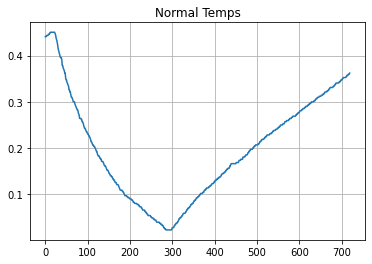

In [13]:
# A graph of a normal hour of temperature data. Try chaning the index value of "train_data" to see how different parts of the dataset look.
plt.grid()
plt.plot(np.arange(720), train_data[0])
plt.title("Normal Temps")
plt.show()

In [14]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(720, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [15]:
autoencoder.compile(optimizer='adam', loss='mae')

In [16]:
history = autoencoder.fit(train_data, train_data, 
          epochs=50, 
          batch_size=16,
          validation_split = 0.1,
        #   validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/50
16/16 [==============================] - 0s 13ms/step - loss: 0.2396 - val_loss: 0.1820
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.1521 - val_loss: 0.1303
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1247 - val_loss: 0.1230
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1208 - val_loss: 0.1207
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1185 - val_loss: 0.1195
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1165 - val_loss: 0.1163
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1120 - val_loss: 0.1096
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1041 - val_loss: 0.0980
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0923 - val_loss: 0.0796
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0704 - val_loss: 0.0592
Epoch 11/50
16/16 

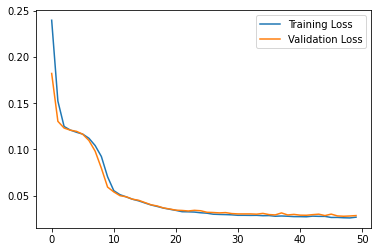

In [17]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

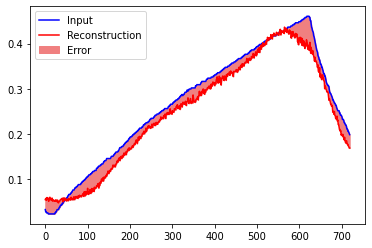

In [18]:
encoded_imgs = autoencoder.encoder(test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(test_data[2],'b')
plt.plot(decoded_imgs[2],'r')
plt.fill_between(np.arange(720), decoded_imgs[2], test_data[2], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
# Path to the dataset from Adafruit.io
# Change <DATASET-NAME> to the file name of the Adafruit.io data you downloaded.
# dataset_path = './dataset/raw/known_anomaly.csv'
dataset_path = './dataset/raw/ms_temperature-20200810-1730.csv'

# Load the dataset using pandas
df_anomaly = pd.read_csv(dataset_path, usecols=[1])

df_anomaly

In [ ]:
# Resort the data set into rows of 1 hour cycles
start_time = 0
samples_per_file = 720

x_train = pd.DataFrame()
arr = []
for i, temp in df_anomaly.iterrows():
    if i % datapoints_per_row == 0 and i != start_time:
        sample = pd.DataFrame(data=arr).T
        x_train = x_train.append(sample, ignore_index=True)
        arr = []
    arr.append(df_anomaly.values[i])
anomaly_data = x_train.values

In [ ]:
anomaly_data

In [ ]:
# min_val = tf.reduce_min(anomaly_data)
# max_val = tf.reduce_max(anomaly_data)


anomaly_data = (anomaly_data - min_val) / (max_val - min_val)
# test_data = (test_data - min_val) / (max_val - min_val)

anomaly_data = tf.cast(anomaly_data, tf.float32)
# test_data = tf.cast(test_data, tf.float32)

In [ ]:
encoded_imgs = autoencoder.encoder(anomaly_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomaly_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(720), decoded_imgs[0], anomaly_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

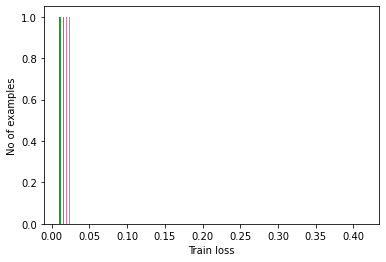

In [19]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [20]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.08013743


In [ ]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [4]:
print('const int input_size = {};'.format(train_data.shape[1]))
print('const float threshold = {};'.format(threshold))
print('const float min_val = {};'.format(min_val))
print('const float max_val = {};'.format(max_val))

NameError: name 'train_data' is not defined

In [21]:
def predict(model, data, threshold):
  reconstructions = model(data)
  print(reconstructions)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [22]:
test = autoencoder.predict(train_data)
test_loss = tf.keras.losses.mae(test, train_data)
print(test_loss)

tf.Tensor(
[0.01340468 0.01273383 0.01019273 0.01088416 0.0121586  0.01165392
 0.01418011 0.00928517 0.01473279 0.01918244 0.01198648 0.01538265
 0.01099623 0.01734855 0.01968713 0.0141937  0.01556463 0.01939954
 0.01548374 0.01001366 0.01879432 0.01373073 0.01279192 0.01288476
 0.01761085 0.02320856 0.01716864 0.12776047 0.01336342 0.0170699
 0.38053796 0.00968457 0.22600318 0.01310931 0.02062008 0.02557223
 0.01116464 0.01815353 0.01452972 0.01443949 0.03795132 0.01101595
 0.01190524 0.01649906 0.01198424 0.01780677 0.01570305 0.02054297
 0.01775009 0.01652458 0.00944917 0.01232571 0.01672101 0.01116195
 0.01728039 0.01452836 0.01738184 0.01367701 0.01184169 0.01150473
 0.01875947 0.0203388  0.01441842 0.01037046 0.14854166 0.01708922
 0.01191462 0.01574021 0.01831156 0.01262417 0.01326413 0.01154761
 0.01490591 0.01872474 0.01220764 0.01008352 0.02056694 0.01323264
 0.01789932 0.01831897 0.01273009 0.01550309 0.02877081 0.01957388
 0.01103013 0.01745405 0.00991164 0.01455581 0.01121

In [ ]:
preds = predict(autoencoder, anomaly_data, threshold)
# print_stats(preds, test_labels)
preds

In [15]:
# Convert the model to a TF Lite flat buffer.
converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
# We optimize the model in order to save room on the microcontroller. Optimizing the model will have a slight affect on the results, but for this use case it won't be a problem.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\adazulay\AppData\Local\Temp\tmpa1n3baim\assets


In [32]:
interpreter = tf.lite.Interpreter(model_path='./model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(train_data[1])
# print([train_data[0]].shape)
interpreter.set_tensor(input_details[0]['index'], [input_data])

interpreter.invoke()

tflite_results = interpreter.get_tensor(output_details[0]['index'])

loss = tf.keras.losses.mae(tflite_results, train_data[1])
print(loss)

[  1 720]


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.01097609], dtype=float32)>